#### MVO Portfolio with Cost Penalty
50M$ dollar-neutral long-short stock portfolio

monthly rebalancing, mvo with tcost penalized, 10 stocks, daily returns 2015-2022

expected returns = cum ret over past year excl. last month

covariance matrix = historical weekly, lookback=52w, half-life=26w

tcost = 1bp per trade notional

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.cluster.hierarchy as sch
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import LinearOperator
import cvxportfolio as cvx

In [74]:
df_ret = pd.read_csv('daily_stock_returns.csv', 
                     index_col=['DATE'], parse_dates=['DATE'])
df_ret = df_ret.pivot(columns=['ID'],values=['RTN'])
df_ret.columns=df_ret.columns.droplevel(0)

In [75]:
# check for nan
df_ret.isna().sum()

ID
8       0
9       0
47      0
48      0
74      0
306     0
743     0
2310    0
4098    0
7839    0
dtype: int64

In [76]:
# check for outlier
df_ret.describe()

ID,8,9,47,48,74,306,743,2310,4098,7839
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,0.000422,0.001004,0.000988,0.000728,0.000965,0.001020,0.002076,0.000468,0.001629,0.000737
std,0.017937,0.017417,0.016431,0.017501,0.018530,0.020601,0.029763,0.023044,0.035094,0.017533
min,-0.122248,-0.147390,-0.172769,-0.116342,-0.128647,-0.140494,-0.187559,-0.263901,-0.210628,-0.111008
25%,-0.007778,-0.006161,-0.006735,-0.006620,-0.007081,-0.008108,-0.011455,-0.008734,-0.014468,-0.006465
50%,0.000000,0.000419,0.000310,0.000357,0.000220,0.000538,0.001654,0.000176,0.000000,0.000386
75%,0.008412,0.009145,0.008314,0.008862,0.009968,0.010618,0.016317,0.011514,0.017642,0.008710
max,0.126868,0.142169,0.127989,0.162584,0.119808,0.141311,0.298067,0.175936,0.198949,0.160524


In [77]:
def get_cumulative_returns(df_ret_d):
    return df_ret_d.add(1).cumprod().sub(1).iloc[-1,:]

def get_returns_period(df_ret_d, days_in_period):
    len_ret = len(df_ret_d)
    idx_ret = [i for i in range(len_ret % days_in_period -1, len_ret, days_in_period)]
    df_ret_p = df_ret.iloc[idx_ret,:]
    k = 0
    for i,j in enumerate(idx_ret):
        df_ret_p.iloc[i,:] = get_cumulative_returns(df_ret_d[k:j])
        k = j
    return df_ret_p

def get_returns_monthly(df_ret_d, days_in_month=22):
    return get_returns_period(df_ret_d, days_in_month)

def get_returns_weekly(df_ret_d, days_in_week=5):
    return get_returns_period(df_ret_d, days_in_week)

def get_expected_returns(df_ret_d, lookback=12, exclusion=-1):
    return get_cumulative_returns(get_returns_monthly(df_ret_d)[-lookback:exclusion])

def get_covariance_matrix(df_ret_d, lookback=52):
    return get_returns_weekly(df_ret_d)[-lookback:].cov()

In [94]:
def single_day_mvo_optimizer(df_ret_d, df_ini_w=None, t=0.0001, a=0.8, thres=0.00000001):
    n = len(df_ret_d.columns)

    df_cov = get_covariance_matrix(df_ret_d)
    df_exp = get_expected_returns(df_ret_d)
    C = np.matrix(df_cov)
    r = np.matrix(df_exp)

    if df_ini_w is None:
        df_ini_w = df_exp.copy()
        df_ini_w.iloc[:] = 0.0
    w0 = list(df_ini_w.values)
    x0 = np.concatenate((w0, np.zeros(n)), axis=None)

    bounds = Bounds(
        np.concatenate((np.full(n, -np.inf), np.zeros(n)), axis=None),
        np.concatenate((np.full(n, np.inf), np.full(n, np.inf)), axis=None)
    )

    m_dollar_neutral = np.matrix(np.concatenate((np.ones(n), np.zeros(n)), axis=None))
    m_chg_wgt_lb = np.concatenate((np.diag(np.ones(n)), np.diag(np.ones(n))), axis=1)
    m_chg_wgt_ub = np.concatenate((np.diag(np.ones(n)), np.diag(np.full(n, -1))), axis=1)
    m_loading = np.concatenate((m_dollar_neutral, m_chg_wgt_lb), axis=0)
    m_loading = np.concatenate((m_loading, m_chg_wgt_ub), axis=0)

    m_lb = np.concatenate((np.zeros(1), w0), axis=None)
    m_lb = np.concatenate((m_lb, np.full(n, -np.inf)), axis=None)

    m_ub = np.concatenate((np.zeros(1), np.full(n, np.inf)), axis=None)
    m_ub = np.concatenate((m_ub, w0), axis=None)

    linear_constraint = LinearConstraint(m_loading, m_lb, m_ub)

    def rosen(x):
        return a*np.matmul(np.matmul(x[:n],C),x[:n].T) - np.matmul(x[:n],r.T) + t*np.sum(x[n:])
    
    res = minimize(rosen, x0, method='trust-constr', 
                   constraints=[linear_constraint], 
                   options={'verbose': 1}, bounds=bounds)
    
    return res

In [95]:
res = single_day_mvo_optimizer(df_ret)
res

C:\Users\tqiu\AppData\Local\Temp\ipykernel_38200\3279074037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ret_p.iloc[i,:] = get_cumulative_returns(df_ret_d[k:j])


`xtol` termination condition is satisfied.
Number of iterations: 319, function evaluations: 7308, CG iterations: 2772, optimality: 2.20e-07, constraint violation: 1.42e-14, execution time: 0.84 s.


           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: -143.5633214098362
                 x: [ 2.213e+02 -9.856e+00 ...  5.778e+01  1.459e+02]
               nit: 319
              nfev: 7308
              njev: 348
              nhev: 0
          cg_niter: 2772
      cg_stop_cond: 4
              grad: [-1.814e-01 -1.812e-01 ...  1.000e-04  1.000e-04]
   lagrangian_grad: [ 8.566e-08 -1.489e-08 ... -1.402e-08  2.329e-08]
            constr: [array([ 1.421e-14,  4.427e+02, ..., -1.156e+02,
                           -2.919e+02]), array([ 2.213e+02, -9.856e+00, ...,  5.778e+01,
                            1.459e+02])]
               jac: [array([[ 1.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           ...,
                           [ 0.000e+00,  0.000e

<Axes: xlabel='ID'>

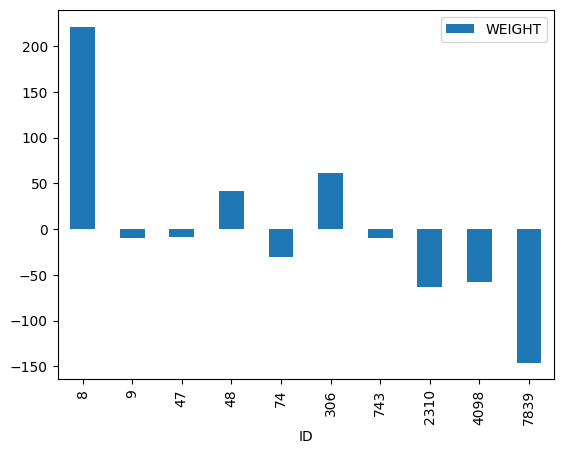

In [102]:
df_opt_w = pd.DataFrame(res.x[:10],index=df_ret.columns, columns=["WEIGHT"])
df_opt_w.plot.bar()